# REINFORCE algorithm

In [ ]:
import numpy as np
import gym
from gym import spaces

class ContinuousInventoryEnv(gym.Env):
    def __init__(self, min_inv=-10, max_inv=10, max_order=10, horizon=100, dist="uniform"):
        super().__init__()
        self.min_inv, self.max_inv = min_inv, max_inv
        self.max_order        = max_order
        self.horizon          = horizon
        self.p, self.a_cost, self.b_cost = 1.0, 1.0, 2.0
        self.sp = 2
        self.dist = dist

        # obs = [inventory level, time step]
        self.observation_space = spaces.Box(
            low=np.array([min_inv, 0], dtype=np.float32),
            high=np.array([max_inv, horizon], dtype=np.float32),
            dtype=np.float32
        )

        # raw policy output ∊ ℝ → scale to [0,max_order]
        self.action_space = spaces.Box(
            low=np.array([0.], dtype=np.float32),
            high=np.array([max_order], dtype=np.float32),
            dtype=np.float32
        )

        self.reset()

    def reset(self):
        self.s = np.random.randint(self.min_inv, self.max_inv+1)
        self.t = 0
        return np.array([self.s, self.t], dtype=np.float32)

    def step(self, action):
        # ensure scalar
        a = float(np.array(action).flatten()[0])
        # enforce bounds
        a = float(max(0, min(a, self.max_order)))
        self.t += 1

        # random continuous demand
        if self.dist == "uniform":
            w = np.random.uniform(0, 10)
        if self.dist == "geometric":
            w = np.random.geometric(0.2)
        if self.dist == "seasonal":
            if self.t <= self.horizon/2:
                w = np.random.uniform(0, 10)
            else:
                w = np.random.uniform(10, 20)

        # next inventory BEFORE clamping
        s_next = self.s + a - w

        # clamp to physical bounds
        s_next_clamped = max(self.min_inv, min(s_next, self.max_inv))
        self.s = s_next_clamped

        # compute cost on clamped inventory
        if s_next_clamped >= 0:
            cost = self.p * a + self.a_cost * s_next_clamped
        else:
            cost = self.p * a + self.b_cost * (-s_next_clamped)

        reward = -cost + w*self.sp
        done   = (self.t >= self.horizon)

        obs = np.array([self.s, self.t], dtype=np.float32)
        return obs, reward, done, {}


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal

class GaussianPolicy(nn.Module):
    def __init__(self, state_dim, hidden_size=128):
        super().__init__()
        self.fc1     = nn.Linear(state_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.mean    = nn.Linear(hidden_size, 1)
        self.log_std = nn.Parameter(torch.zeros(1))
        self.max_order = 10

    def forward(self, x):
        x  = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mu = self.mean(x)
        std = torch.exp(self.log_std).clamp(min=1e-3, max=2.0)
        return mu, std

    def get_action(self, state):
        mu, std = self(state)
        dist = Normal(mu, std)
        raw_a = dist.rsample()                   # reparam sample
        # squash to [0, max_order]
        a = torch.tanh(raw_a) * (self.max_order/2) + (self.max_order/2)
        logp = dist.log_prob(raw_a) - torch.log(
            (self.max_order/2) * (1 - torch.tanh(raw_a)**2) + 1e-6
        )
        logp = logp.sum(-1)
        return a, logp


In [13]:
import torch.optim as optim
import matplotlib.pyplot as plt

q_values = []  # track average Q-value per episode

def reinforce_cont(env, policy, num_episodes=500, gamma=1.0, lr=1e-3, log_interval=10):
    optimizer = optim.Adam(policy.parameters(), lr=lr)
    all_rewards = []

    for ep in range(1, num_episodes + 1):
        state = env.reset()
        log_probs, rewards = [], []
        done = False

        while not done:
            state_tensor = torch.from_numpy(state).float().unsqueeze(0)
            action_tensor, logp = policy.get_action(state_tensor)

            # convert to numpy scalar in [0, max_order]
            action_np = action_tensor.detach().numpy().flatten()[0]
            next_state, reward, done, _ = env.step(action_np)

            log_probs.append(logp)
            rewards.append(reward)
            state = next_state

        # compute discounted returns
        returns = []
        G = 0
        for r in reversed(rewards):
            G = r + gamma * G
            returns.insert(0, G)
        returns = torch.tensor(returns, dtype=torch.float32)
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)
        # average return as proxy for average Q(s,a)
        avg_q = returns.mean().item()
        q_values.append(avg_q)


        # policy gradient step
        loss = torch.stack([-lp * Gt for lp, Gt in zip(log_probs, returns)]).sum()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_reward = sum(rewards)
        all_rewards.append(total_reward)
        if ep % log_interval == 0:
            print(f"Episode {ep}/{num_episodes}, total reward: {total_reward:.2f}")

    all_rew = [-1*i for i in all_rewards]
    plt.scatter(range(len(all_rewards)), all_rew, s=4)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('REINFORCE Continuous Action Learning Curve')
    plt.grid(True)
    plt.show()

    return all_rewards


Episode 10/2000, total reward: -1615.29
Episode 20/2000, total reward: -1416.48
Episode 30/2000, total reward: -3899.03
Episode 40/2000, total reward: -4229.38
Episode 50/2000, total reward: -1384.73
Episode 60/2000, total reward: -3968.72
Episode 70/2000, total reward: -1249.20
Episode 80/2000, total reward: -3411.30
Episode 90/2000, total reward: -4372.98
Episode 100/2000, total reward: -3321.56
Episode 110/2000, total reward: -4123.93
Episode 120/2000, total reward: -4205.60
Episode 130/2000, total reward: -3396.64
Episode 140/2000, total reward: -4400.00
Episode 150/2000, total reward: -4161.00
Episode 160/2000, total reward: -4226.99
Episode 170/2000, total reward: -3817.91
Episode 180/2000, total reward: -4295.63
Episode 190/2000, total reward: -4359.45
Episode 200/2000, total reward: -4385.03
Episode 210/2000, total reward: -3965.48
Episode 220/2000, total reward: -3215.29
Episode 230/2000, total reward: -3777.16
Episode 240/2000, total reward: -4347.78
Episode 250/2000, total r

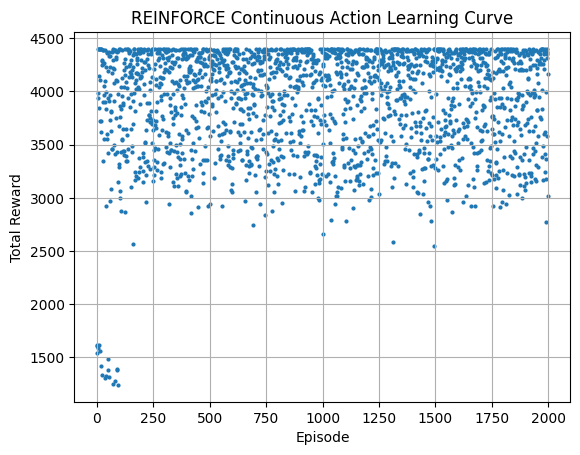

In [14]:
if __name__ == "__main__":
    env = ContinuousInventoryEnv(min_inv=-20, max_inv=100, max_order=10, horizon=40)
    policy = GaussianPolicy(state_dim=env.observation_space.shape[0])
    reinforce_cont(env, policy, num_episodes=2000, gamma=0.9, lr=1e-3)


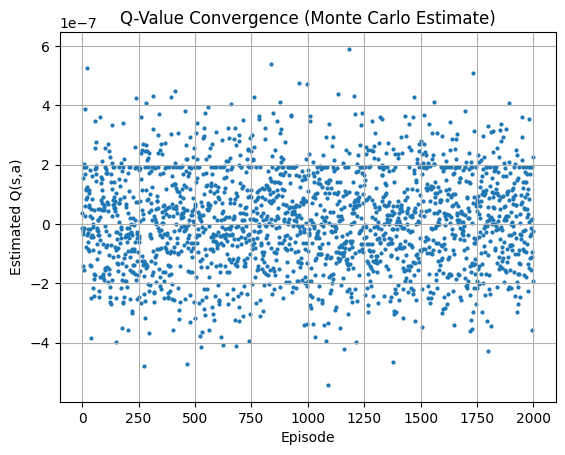

In [15]:
plt.figure()
plt.scatter(range(len(q_values)), q_values, s=4)
plt.xlabel('Episode')
plt.ylabel('Estimated Q(s,a)')
plt.title('Q-Value Convergence (Monte Carlo Estimate)')
plt.grid(True)
plt.show()


In [16]:
import numpy as np
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import defaultdict

def reinforce_cont(env, policy, num_episodes=500, gamma=1.0, lr=1e-3, log_interval=50):
    optimizer = optim.Adam(policy.parameters(), lr=lr)

    all_rewards   = []      # total undiscounted reward per episode
    q_values      = []      # G_0 per episode
    state_returns = []      # list of (t, G_t) across all episodes
    v_fixed_state = []      # one rollout-from-s* estimate per episode

    fixed_state = None      # will hold the [s*, t*] vector

    for ep in range(1, num_episodes+1):
        # ——— 1) Run one training episode ———
        state = env.reset()                      # state is np.array([s, t])
        if fixed_state is None:
            fixed_state = state.copy()           # capture s* and t* from ep=1

        log_probs, rewards = [], []
        ep_times = []     # to record (t, reward) pairs for this ep
        done = False

        while not done:
            st_t = torch.from_numpy(state).float().unsqueeze(0)
            action_t, logp_t = policy.get_action(st_t)
            a = action_t.detach().item()

            next_state, r, done, _ = env.step(a)
            ep_times.append((env.t, r))
            log_probs.append(logp_t)
            rewards.append(r)
            state = next_state

        # ——— 2) Compute G_t for this episode ———
        returns = []
        G = 0
        for r in reversed(rewards):
            G = r + gamma * G
            returns.insert(0, G)
        returns = torch.tensor(returns, dtype=torch.float32)

        # record total reward & Q_0
        all_rewards.append(-sum(rewards))
        q_values.append(returns[0].item())

        # accumulate for global V(s) vs t
        for (t_step, _), Gt in zip(ep_times, returns):
            state_returns.append((t_step, Gt.item()))

        # ——— 3) Policy gradient update ———
        norm_R = (returns - returns.mean()) / (returns.std() + 1e-8)
        loss = torch.stack([-lp * Gt for lp, Gt in zip(log_probs, norm_R)]).sum()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # ——— 4) Evaluate V(s*) by a fresh rollout from fixed_state ———
        s_star, t_star = fixed_state
        env.s = float(s_star)  # unpack properly
        env.t = int(t_star)
        state = np.array([env.s, env.t], dtype=np.float32)

        G_eval = 0.0
        discount = 1.0
        done = False
        while not done:
            st_t = torch.from_numpy(state).float().unsqueeze(0)
            a_t, _ = policy.get_action(st_t)
            a = a_t.detach().item()
            state, r, done, _ = env.step(a)
            G_eval += discount * r
            discount *= gamma

        v_fixed_state.append(G_eval)

        if ep % log_interval == 0:
            print(f"[Episode {ep}/{num_episodes}]  Reward: {all_rewards[-1]:.1f}  "
                  f"Q₀: {q_values[-1]:.1f}  V(s*): {v_fixed_state[-1]:.1f}")

    # === PLOT 1: Total Reward per Episode ===
    plt.figure(figsize=(6,4))
    plt.plot(all_rewards)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Learning Curve: Total Reward")
    plt.grid(True)

    # === PLOT 2: Q-Value Convergence (G₀) ===
    plt.figure(figsize=(6,4))
    plt.plot(q_values)
    plt.xlabel("Episode")
    plt.ylabel(r"$G_0 = Q(s_0,a_0)$")
    plt.title("Q-Value Convergence")
    plt.grid(True)

    # === PLOT 3: Average Return-to-Go vs Time t ===
    sums, counts = defaultdict(float), defaultdict(int)
    for t_step, Gt in state_returns:
        sums[t_step] += Gt
        counts[t_step] += 1

    t_vals = sorted(sums.keys())
    avg_Gt = [sums[t]/counts[t] for t in t_vals]

    plt.figure(figsize=(6,4))
    plt.plot(t_vals, avg_Gt, marker='o')
    plt.xlabel("Time step $t$")
    plt.ylabel(r"Avg Return-to-Go $G_t$")
    plt.title("Average Return-to-Go vs Time")
    plt.grid(True)

    # === PLOT 4: V(s*) vs Episode ===
    plt.figure(figsize=(6,4))
    plt.plot(v_fixed_state)
    plt.xlabel("Episode")
    plt.ylabel(r"Estimated $V(s^*)$")
    plt.title("Value of Fixed State $s^*$ Over Training")
    plt.grid(True)

    plt.show()

    return all_rewards, q_values, (t_vals, avg_Gt), v_fixed_state


[Episode 50/2000]  Reward: 2758.1  Q₀: -377.4  V(s*): -415.5
[Episode 100/2000]  Reward: 2608.4  Q₀: -409.0  V(s*): -373.1
[Episode 150/2000]  Reward: 2682.4  Q₀: -449.9  V(s*): -378.2
[Episode 200/2000]  Reward: 1334.2  Q₀: -509.6  V(s*): -210.3
[Episode 250/2000]  Reward: 681.1  Q₀: -295.2  V(s*): -218.1
[Episode 300/2000]  Reward: 895.5  Q₀: -438.9  V(s*): -177.5
[Episode 350/2000]  Reward: 686.6  Q₀: -289.6  V(s*): -215.2
[Episode 400/2000]  Reward: 513.9  Q₀: -113.0  V(s*): -206.2
[Episode 450/2000]  Reward: 416.2  Q₀: -103.8  V(s*): -168.7
[Episode 500/2000]  Reward: 382.8  Q₀: -110.2  V(s*): -160.6
[Episode 550/2000]  Reward: 731.7  Q₀: -326.1  V(s*): -208.6
[Episode 600/2000]  Reward: 585.9  Q₀: -200.3  V(s*): -172.2
[Episode 650/2000]  Reward: 885.4  Q₀: -409.7  V(s*): -170.6
[Episode 700/2000]  Reward: 964.3  Q₀: -464.7  V(s*): -177.4
[Episode 750/2000]  Reward: 602.4  Q₀: -268.7  V(s*): -172.8
[Episode 800/2000]  Reward: 409.3  Q₀: -96.4  V(s*): -190.6
[Episode 850/2000]  Re

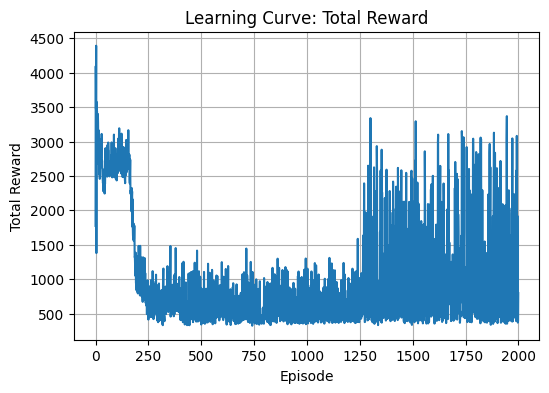

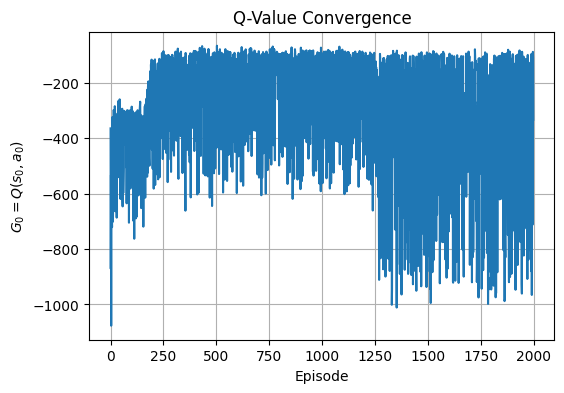

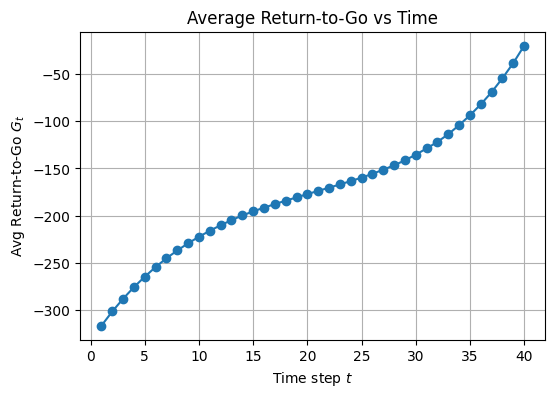

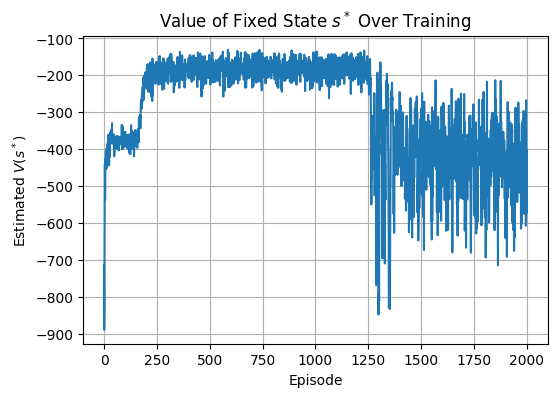

In [17]:
if __name__ == "__main__":
    env = ContinuousInventoryEnv(min_inv=-20, max_inv=100, max_order=10, horizon=40)
    policy = GaussianPolicy(state_dim=env.observation_space.shape[0])
    reinforce_cont(env, policy, num_episodes=2000, gamma=0.9, lr=1e-3)


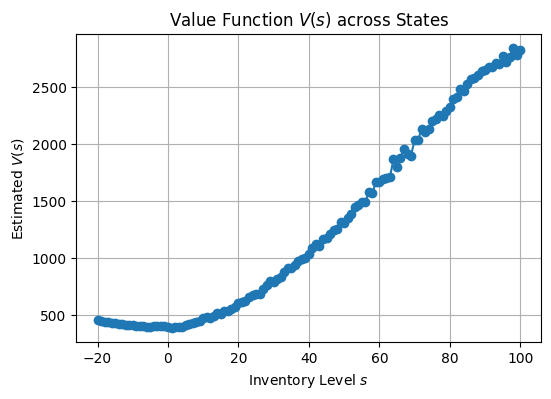

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

def estimate_V_of_s(env, policy, states, num_rollouts=200, gamma=1.0):
    V = {}
    for s0 in states:
        returns = []
        for _ in range(num_rollouts):
            # reset env to exactly s0
            env.s = s0
            env.t = 0
            state = np.array([env.s, env.t], dtype=np.float32)

            G = 0; discount = 1.0
            done = False
            while not done:
                st_t = torch.from_numpy(state).float().unsqueeze(0)
                action_t, _ = policy.get_action(st_t)
                a = action_t.detach().numpy().flatten()[0]
                next_state, r, done, _ = env.step(a)
                G += discount * r
                discount *= gamma
                state = next_state
            returns.append(G)
        V[s0] = np.mean(returns)
    
    # plot
    s_vals = sorted(V.keys())
    v_vals = [-V[s] for s in s_vals]
    plt.figure(figsize=(6,4))
    plt.plot(s_vals, v_vals, marker='o')
    plt.xlabel("Inventory Level $s$")
    plt.ylabel("Estimated $V(s)$")
    plt.title("Value Function $V(s)$ across States")
    plt.grid(True)
    plt.show()
    return V

# Usage (after training):
states = range(env.min_inv, env.max_inv+1)
V_est = estimate_V_of_s(env, policy, states)


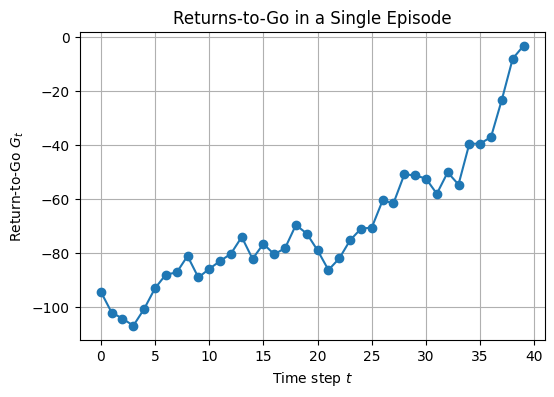

In [19]:
gamma = 0.9

# generate one trajectory
state = env.reset()
done = False
rewards = []
while not done:
    st_t = torch.from_numpy(state).float().unsqueeze(0)
    action_t, _ = policy.get_action(st_t)
    a = action_t.detach().numpy().flatten()[0]
    state, r, done, _ = env.step(a)
    rewards.append(r)

# compute G_t
G = 0
returns_to_go = []
for r in reversed(rewards):
    G = r + gamma*G
    returns_to_go.insert(0, G)

# plot
plt.figure(figsize=(6,4))
plt.plot(range(len(returns_to_go)), returns_to_go, marker='o')
plt.xlabel("Time step $t$")
plt.ylabel(r"Return-to-Go $G_t$")
plt.title("Returns-to-Go in a Single Episode")
plt.grid(True)
plt.show()


# Binomial distribution

[Episode 50/2000]  Reward: 1103.4  Q₀: -130.0  V(s*): -147.9
[Episode 100/2000]  Reward: 1154.6  Q₀: -190.0  V(s*): -140.6
[Episode 150/2000]  Reward: 1445.4  Q₀: -336.0  V(s*): -195.7
[Episode 200/2000]  Reward: 1341.2  Q₀: -304.9  V(s*): -170.9
[Episode 250/2000]  Reward: 1246.0  Q₀: -270.5  V(s*): -177.1
[Episode 300/2000]  Reward: 1167.5  Q₀: -183.7  V(s*): -155.8
[Episode 350/2000]  Reward: 1627.3  Q₀: -555.9  V(s*): -191.7
[Episode 400/2000]  Reward: 1889.5  Q₀: -658.0  V(s*): -178.2
[Episode 450/2000]  Reward: 1036.5  Q₀: -127.7  V(s*): -185.7
[Episode 500/2000]  Reward: 580.0  Q₀: -141.7  V(s*): -106.8
[Episode 550/2000]  Reward: 1291.1  Q₀: -518.5  V(s*): -82.4
[Episode 600/2000]  Reward: 1055.7  Q₀: -511.7  V(s*): -129.8
[Episode 650/2000]  Reward: 1121.2  Q₀: -526.6  V(s*): -74.2
[Episode 700/2000]  Reward: 911.3  Q₀: -393.7  V(s*): -107.2
[Episode 750/2000]  Reward: 1486.1  Q₀: -329.2  V(s*): -192.7
[Episode 800/2000]  Reward: 1150.0  Q₀: -166.9  V(s*): -131.7
[Episode 850/

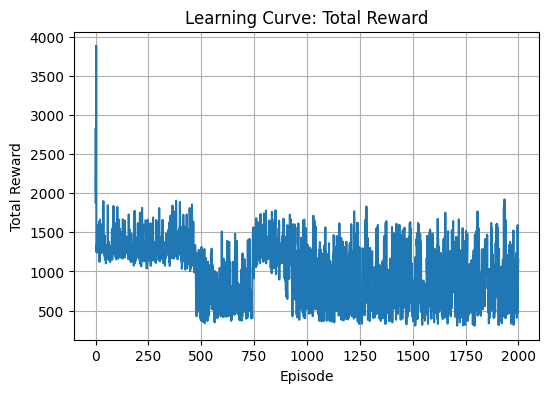

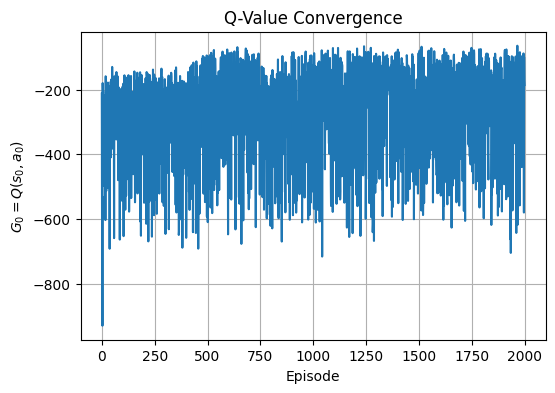

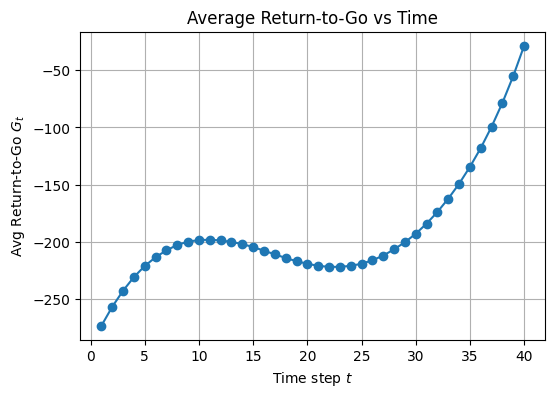

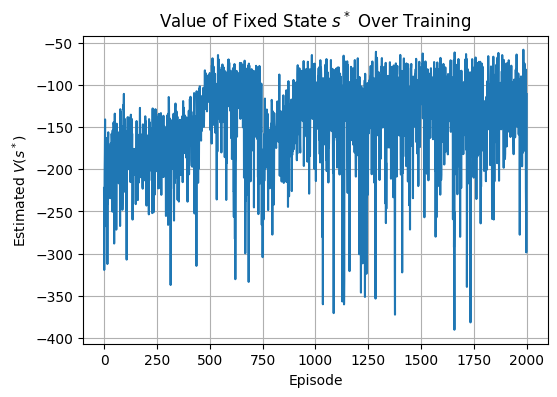

In [21]:
if __name__ == "__main__":
    env = ContinuousInventoryEnv(min_inv=-20, max_inv=100, max_order=10, horizon=40, dist="geometric")
    policy = GaussianPolicy(state_dim=env.observation_space.shape[0])
    reinforce_cont(env, policy, num_episodes=2000, gamma=0.9, lr=1e-3)


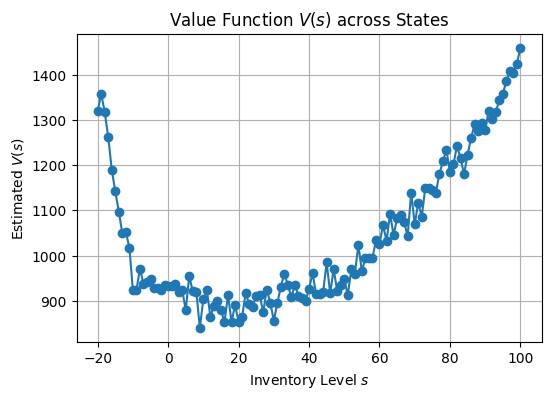

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

def estimate_V_of_s(env, policy, states, num_rollouts=200, gamma=1.0):
    V = {}
    for s0 in states:
        returns = []
        for _ in range(num_rollouts):
            # reset env to exactly s0
            env.s = s0
            env.t = 0
            state = np.array([env.s, env.t], dtype=np.float32)

            G = 0; discount = 1.0
            done = False
            while not done:
                st_t = torch.from_numpy(state).float().unsqueeze(0)
                action_t, _ = policy.get_action(st_t)
                a = action_t.detach().numpy().flatten()[0]
                next_state, r, done, _ = env.step(a)
                G += discount * r
                discount *= gamma
                state = next_state
            returns.append(G)
        V[s0] = np.mean(returns)
    
    # plot
    s_vals = sorted(V.keys())
    v_vals = [-V[s] for s in s_vals]
    plt.figure(figsize=(6,4))
    plt.plot(s_vals, v_vals, marker='o')
    plt.xlabel("Inventory Level $s$")
    plt.ylabel("Estimated $V(s)$")
    plt.title("Value Function $V(s)$ across States")
    plt.grid(True)
    plt.show()
    return V

# Usage (after training):
states = range(env.min_inv, env.max_inv+1)
V_est = estimate_V_of_s(env, policy, states)


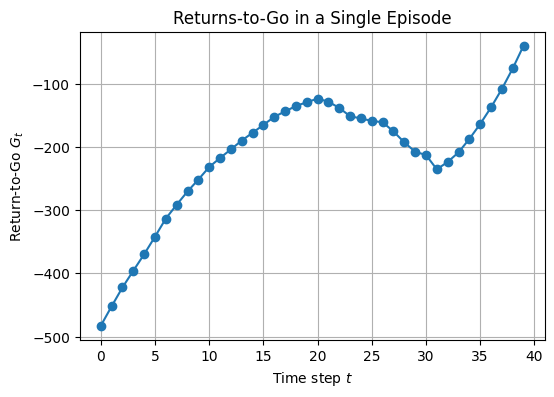

In [23]:
gamma = 0.9

# generate one trajectory
state = env.reset()
done = False
rewards = []
while not done:
    st_t = torch.from_numpy(state).float().unsqueeze(0)
    action_t, _ = policy.get_action(st_t)
    a = action_t.detach().numpy().flatten()[0]
    state, r, done, _ = env.step(a)
    rewards.append(r)

# compute G_t
G = 0
returns_to_go = []
for r in reversed(rewards):
    G = r + gamma*G
    returns_to_go.insert(0, G)

# plot
plt.figure(figsize=(6,4))
plt.plot(range(len(returns_to_go)), returns_to_go, marker='o')
plt.xlabel("Time step $t$")
plt.ylabel(r"Return-to-Go $G_t$")
plt.title("Returns-to-Go in a Single Episode")
plt.grid(True)
plt.show()


# Seasonal demand

[Episode 50/2000]  Reward: 2392.4  Q₀: -504.9  V(s*): -714.1
[Episode 100/2000]  Reward: 1244.3  Q₀: -155.0  V(s*): -179.9
[Episode 150/2000]  Reward: 1213.8  Q₀: -188.6  V(s*): -189.0
[Episode 200/2000]  Reward: 1175.5  Q₀: -145.3  V(s*): -196.1
[Episode 250/2000]  Reward: 1476.6  Q₀: -370.5  V(s*): -206.6
[Episode 300/2000]  Reward: 1676.6  Q₀: -467.0  V(s*): -209.2
[Episode 350/2000]  Reward: 1463.1  Q₀: -345.3  V(s*): -198.3
[Episode 400/2000]  Reward: 1250.9  Q₀: -168.7  V(s*): -202.5
[Episode 450/2000]  Reward: 1777.5  Q₀: -558.8  V(s*): -193.3
[Episode 500/2000]  Reward: 1218.8  Q₀: -153.2  V(s*): -203.0
[Episode 550/2000]  Reward: 1315.3  Q₀: -267.2  V(s*): -231.2
[Episode 600/2000]  Reward: 1641.8  Q₀: -482.4  V(s*): -208.9
[Episode 650/2000]  Reward: 1900.6  Q₀: -554.8  V(s*): -215.9
[Episode 700/2000]  Reward: 1448.6  Q₀: -287.9  V(s*): -191.8
[Episode 750/2000]  Reward: 1272.0  Q₀: -172.3  V(s*): -251.0
[Episode 800/2000]  Reward: 1520.7  Q₀: -295.4  V(s*): -219.6
[Episode 

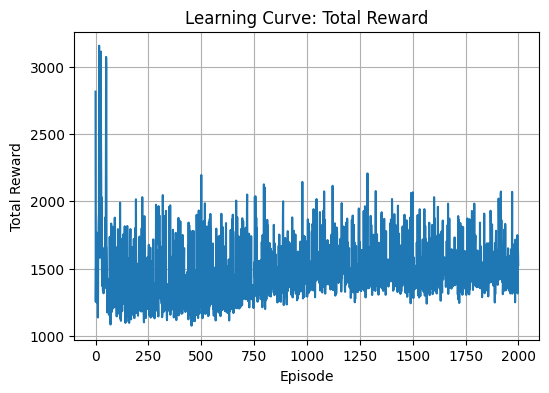

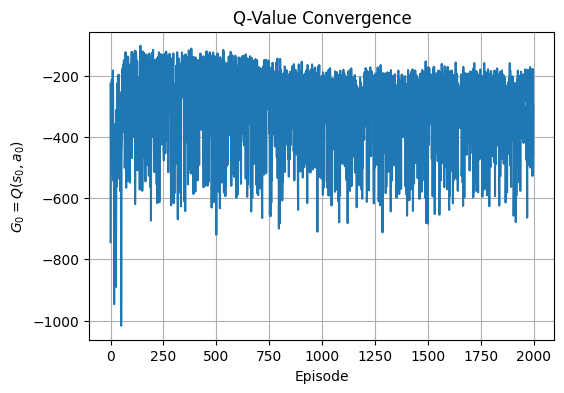

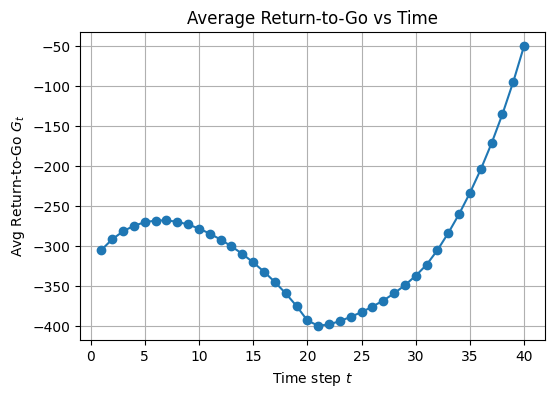

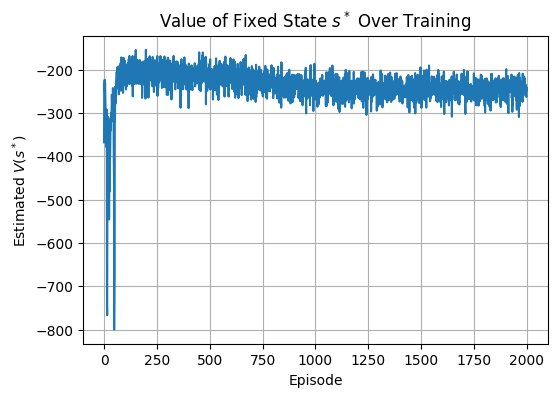

In [26]:
if __name__ == "__main__":
    env = ContinuousInventoryEnv(min_inv=-20, max_inv=100, max_order=10, horizon=40, dist="seasonal")
    policy = GaussianPolicy(state_dim=env.observation_space.shape[0])
    reinforce_cont(env, policy, num_episodes=2000, gamma=0.9, lr=1e-3)


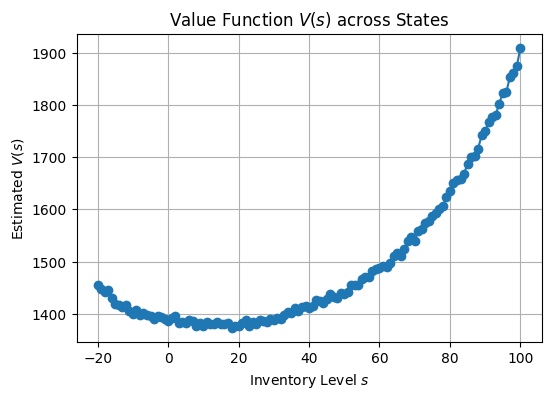

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

def estimate_V_of_s(env, policy, states, num_rollouts=200, gamma=1.0):
    V = {}
    for s0 in states:
        returns = []
        for _ in range(num_rollouts):
            # reset env to exactly s0
            env.s = s0
            env.t = 0
            state = np.array([env.s, env.t], dtype=np.float32)

            G = 0; discount = 1.0
            done = False
            while not done:
                st_t = torch.from_numpy(state).float().unsqueeze(0)
                action_t, _ = policy.get_action(st_t)
                a = action_t.detach().numpy().flatten()[0]
                next_state, r, done, _ = env.step(a)
                G += discount * r
                discount *= gamma
                state = next_state
            returns.append(G)
        V[s0] = np.mean(returns)
    
    # plot
    s_vals = sorted(V.keys())
    v_vals = [-V[s] for s in s_vals]
    plt.figure(figsize=(6,4))
    plt.plot(s_vals, v_vals, marker='o')
    plt.xlabel("Inventory Level $s$")
    plt.ylabel("Estimated $V(s)$")
    plt.title("Value Function $V(s)$ across States")
    plt.grid(True)
    plt.show()
    return V

# Usage (after training):
states = range(env.min_inv, env.max_inv+1)
V_est = estimate_V_of_s(env, policy, states)


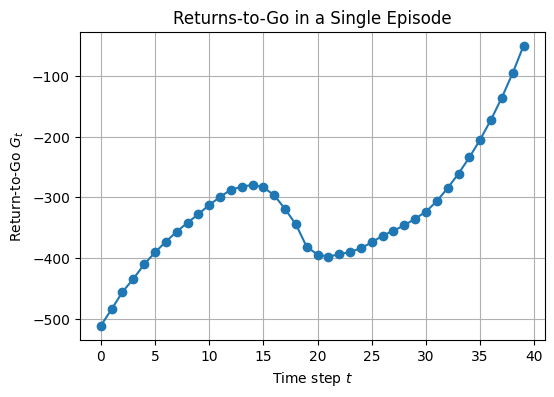

In [28]:
gamma = 0.9

# generate one trajectory
state = env.reset()
done = False
rewards = []
while not done:
    st_t = torch.from_numpy(state).float().unsqueeze(0)
    action_t, _ = policy.get_action(st_t)
    a = action_t.detach().numpy().flatten()[0]
    state, r, done, _ = env.step(a)
    rewards.append(r)

# compute G_t
G = 0
returns_to_go = []
for r in reversed(rewards):
    G = r + gamma*G
    returns_to_go.insert(0, G)

# plot
plt.figure(figsize=(6,4))
plt.plot(range(len(returns_to_go)), returns_to_go, marker='o')
plt.xlabel("Time step $t$")
plt.ylabel(r"Return-to-Go $G_t$")
plt.title("Returns-to-Go in a Single Episode")
plt.grid(True)
plt.show()
